In [39]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [4]:
# Import thr dataset (train and test)
train_df = pd.read_csv("./train.csv")
valid_df = pd.read_csv("./test.csv")

In [5]:
train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [6]:
valid_df.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [7]:
# Check the dimension of the train and valid dataset
train_df.shape, valid_df.shape

((2000, 21), (1000, 21))

In [8]:
# Is there any Nan Value 
train_df.isnull().sum().sum(), valid_df.isnull().sum().sum()

(0, 0)

In [16]:
# Is there any object or categorical features in the dataset
"Categorical or object features"\
    if train_df.dtypes[train_df.dtypes == "object"].shape[0] > 0\
else "No evidence of categorical features"

'No evidence of categorical features'

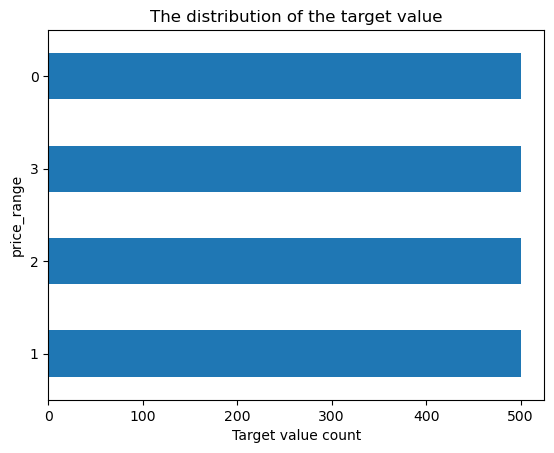

In [28]:
# Check the distribution of the target value
plt.title("The distribution of the target value")
train_df.iloc[:, -1].value_counts().plot(kind = "barh")
plt.xlabel("Target value count")
plt.show()

In [31]:
# Split the data into train ans test
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

validation = valid_df.iloc[:, :].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.30, random_state = 42
)

In [35]:
# Do the scaling

scaler = StandardScaler()

X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)
valid_df_transformed = scaler.fit_transform(valid_df)

In [70]:
# Going to use Logistic Regression, AdaBoost, Gradient boosting
def objective(trails):
    classifiers = trails.suggest_categorical("classifier", ["LR", "ADB", "GB"])
    
    C = trails.suggest_float("C", 1.0, 10)
    
    n_estimators = trails.suggest_categorical("n_estimators", [50, 100, 200, 250, 300])
    learning_rate = trails.suggest_float("learning_rate", 0.01, 1.0)
    
    min_samples_split = trails.suggest_int("min_samples_split", 3, 15)
    max_depth = trails.suggest_int("max_depth", 5, 15)
    
    
    if classifiers == "LR":
        model = LogisticRegression(
            C = C
        )
        
    elif classifiers == "ADB":
        model = AdaBoostClassifier(
            n_estimators = n_estimators, learning_rate = learning_rate
        )
        
    elif classifiers == "GB":
        model = GradientBoostingClassifier(
            n_estimators = n_estimators,
            learning_rate = learning_rate,
            min_samples_split = min_samples_split,
            max_depth = max_depth
        )
        
    score =  cross_val_score(
        estimator=model,
        X = X_train_transformed,
        y = y_train,
        cv=5,
        scoring="accuracy"
    )
    
    return score.mean()

In [71]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(func=objective, n_trials=50)

[I 2024-11-06 14:06:07,141] A new study created in memory with name: no-name-4821f7af-5fd0-46cb-9535-934f2883b64e
[I 2024-11-06 14:06:07,562] Trial 0 finished with value: 0.9650000000000001 and parameters: {'classifier': 'LR', 'C': 9.26951844060266, 'n_estimators': 100, 'learning_rate': 0.5800639830348673, 'min_samples_split': 13, 'max_depth': 10}. Best is trial 0 with value: 0.9650000000000001.
[I 2024-11-06 14:07:38,365] Trial 1 finished with value: 0.8535714285714286 and parameters: {'classifier': 'GB', 'C': 1.9335782491651727, 'n_estimators': 200, 'learning_rate': 0.06085203577232077, 'min_samples_split': 5, 'max_depth': 15}. Best is trial 0 with value: 0.9650000000000001.
/opt/anaconda3/envs/GPSG/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/GPSG/lib/python3.10/site-packages/sk

In [94]:
!pip install plotly

In [97]:
import plotly
print(plotly.__version__)


5.24.1


/var/folders/_z/50gjfd191tb06rhqtkk60fvh0000gn/T/ipykernel_6801/228779507.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna_matplotlib.plot_parallel_coordinate(study)


<Axes: title={'center': 'Parallel Coordinate Plot'}>

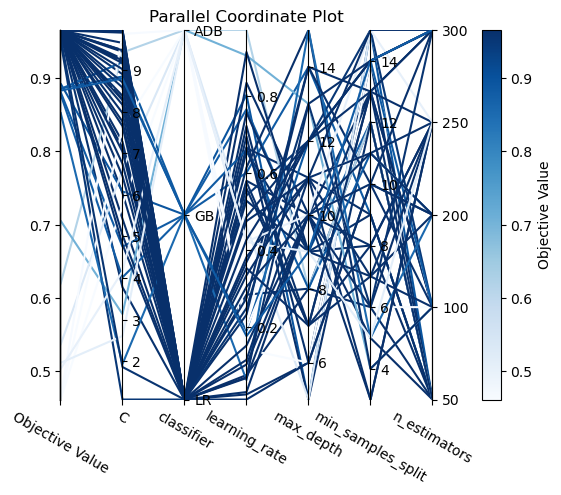

In [98]:
import optuna.visualization.matplotlib as optuna_matplotlib
optuna_matplotlib.plot_parallel_coordinate(study)


/var/folders/_z/50gjfd191tb06rhqtkk60fvh0000gn/T/ipykernel_6801/885309847.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

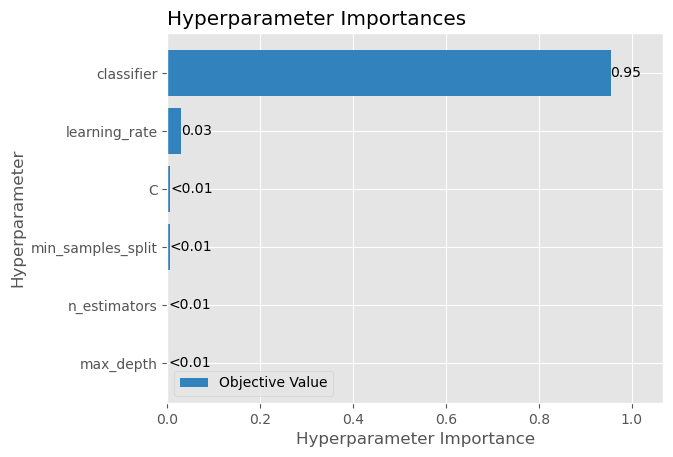

In [102]:
optuna_matplotlib.plot_param_importances(study)

/var/folders/_z/50gjfd191tb06rhqtkk60fvh0000gn/T/ipykernel_6801/3410293224.py:1: ExperimentalWarning:

plot_rank is experimental (supported from v3.2.0). The interface can change in the future.

[W 2024-11-06 14:27:56,315] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


array([[<Axes: ylabel='C'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='classifier'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='learning_rate'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='max_depth'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='min_samples_split'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: xlabel='C', ylabel='n_estimators'>,
        <Axes: xlabel='classifier'>, <Axes: xlabel='learning_rate'>,
        <Axes: xlabel='max_depth'>, <Axes: xlabel='min_samples_split'>,
        <Axes: xlabel='n_estimators'>]], dtype=object)

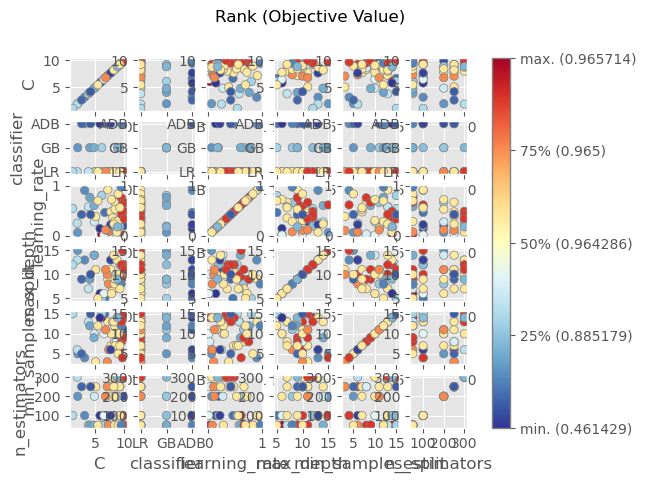

In [106]:
optuna_matplotlib.plot_rank(study)

In [72]:
# Find the best params for this particular dataset
study.best_params

{'classifier': 'LR',
 'C': 6.044273335896621,
 'n_estimators': 50,
 'learning_rate': 0.023367897716356528,
 'min_samples_split': 14,
 'max_depth': 6}

In [79]:
study.best_params["C"]

6.044273335896621

In [80]:
# So going to use LR

classifier = LogisticRegression(
    C=study.best_params["C"]
)

classifier.fit(X_train_transformed, y_train)

predicted = classifier.predict(X_test_transformed)


In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

(
    accuracy_score(predicted, y_test),
    precision_score(predicted, y_test, average="macro"),
    recall_score(predicted, y_test, average="macro"),
    f1_score(predicted, y_test, average="macro")
)

(0.9616666666666667,
 0.9615325876836267,
 0.9624823937078539,
 0.9614323611848364)